## Data Preprocessing

In [1]:
from statsmodels.tsa.stattools import coint
from tempdisagg import TempDisaggModel
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('Data/Macro.csv')
data['Exports_numeric'] = pd.to_numeric(data['Exports'], errors='coerce')
data['Imports_numeric'] = pd.to_numeric(data['Imports'], errors='coerce')
data['USDPHP_numeric'] = pd.to_numeric(data['USDPHP'], errors='coerce')

data['Monthly_Trade_PHP'] = (
    data['Exports_numeric'] + data['Imports_numeric']
) * data['USDPHP_numeric']

# Create quarterly trade by summing 3 months
data['Date'] = pd.to_datetime(data['Year'].astype(str) + '-' + 
                             data['Month'].astype(str) + '-01')
data.set_index('Date', inplace=True)

# Resample to quarterly sum
quarterly_trade = data['Monthly_Trade_PHP'].resample('QE').sum()

# Get quarterly GDP (remove NaNs)
quarterly_gdp = data['Nominal GDP'].resample('QE').mean().dropna()

# Align both series on common dates
start, end = "1991-01-01", "2004-12-31"

gdp_series = quarterly_gdp.loc[start:end]
trade_series = quarterly_trade.loc[start:end]

# Test for cointegration
coint(gdp_series, trade_series, autolag='AIC')


(np.float64(-2.3757208699955488),
 np.float64(0.3364386725432962),
 array([-4.10664876, -3.44947826, -3.1224619 ]))

In [52]:
from disaggregation import main
subset = main() 
subset.head()

Disaggregated CSV exists. Loading...


,Unnamed: 3,Inflation,Population,GDP,Imports,Exports,Agriculture,Industry,Services,USDPHP,Nominal GDP,TotalTrade,TotalTrade_PHPMN,NominalGDP_disagg,Pop_disagg
0,1/1/1992,10.9,NaN,NaN,1037.69,662.37,NaN,NaN,NaN,26.5446,NaN,1700.06,45127.41268,136347.8527,63004203.31
1,2/1/1992,9.1,NaN,NaN,1032.51,714.90,NaN,NaN,NaN,26.1580,NaN,1747.41,45708.75078,137765.5289,62965193.58
2,3/1/1992,8.7,NaN,1244652.42,1164.81,898.46,18.11,32.58,49.3,25.8102,362800.0,2063.27,53253.41135,128415.5503,62929730.18
3,4/1/1992,8.4,NaN,NaN,1196.81,666.45,NaN,NaN,NaN,25.6672,NaN,1863.26,47824.66707,120089.5621,62897813.13
4,5/1/1992,8.9,NaN,NaN,1186.29,811.71,NaN,NaN,NaN,26.1496,NaN,1998.00,52246.90080,124258.7011,62869442.41


In [53]:
!python disaggregation.py

Disaggregated CSV exists. Loading...


## Model Building

for testing/reference only

actual code already in separate scripts, go straight to tuning to use

In [1]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from sklearn.model_selection import TimeSeriesSplit

import random

import os
import json


if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [2]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.X) - self.seq_len 
        
    def __getitem__(self, idx):
        return (self.X[idx:idx+self.seq_len], self.y[idx+self.seq_len])

In [3]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=3, dropout=0.2):
        super(GRUModel, self).__init__()
        
        # GRU layer
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0  # Changed from dropout to 0
        )
        
        # Add manual dropout layer
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.dropout(out)  # Apply dropout manually here
        out = self.fc(out)
        return out

In [4]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()
    def forward(self, predictions, targets):       
        return torch.sqrt(self.mse(predictions, targets) + 1e-6)
        
class MAPELoss(nn.Module):
    def __init__(self, epsilon=1e-8):
        super(MAPELoss, self).__init__()
        self.epsilon = epsilon  # Small constant to prevent division by zero

    def forward(self, output, target):
        return torch.mean(torch.abs((target - output) / (target + self.epsilon)))*100

In [5]:
class Arguments:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [6]:
def set_seed(seed=None):
    if seed is None:
        seed = 1
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Remove CUDA-specific settings for Mac
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    
    # MPS doesn't need special deterministic settings
    os.environ['PYTHONHASHSEED'] = str(seed)

In [7]:
def split_data(X, use_val=True):
    if use_val:
        train_size = int(0.6 * len(X))
        val_size = int(0.2 * len(X))

        train = X[:train_size]
        val = X[train_size:train_size + val_size]
        test = X[train_size + val_size:]

        return train, val, test

In [8]:
from sklearn.preprocessing import MinMaxScaler
import pickle

def transform_data(data, save_path="Transforms/scaler.pkl"):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    with open(save_path, "wb") as f:
        pickle.dump(scaler, f)
    
    return data_scaled

def inverse_transform(data, load_path="Transforms/scaler.pkl"):
    with open(load_path, "rb") as f:
        scaler = pickle.load(f)
    return scaler.inverse_transform(data)

In [9]:
def train_model(model, dataloader, device, optimizer, criterion):

    model.train()
    total_loss = 0.0
    total_samples = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

    return total_loss / total_samples if total_samples > 0 else 0.0

@torch.no_grad()
def evaluate(model, dataloader, device, criterion, args):

    model.eval()
    total_loss = 0.0
    total_samples = 0
    all_preds = []
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)


        outputs = model(inputs)
        loss = criterion(outputs, targets)

        total_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)
        all_preds.append(outputs.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    avg_loss = total_loss / total_samples if total_samples > 0 else 0.0

    return avg_loss, all_preds

In [ ]:
def run(model, train_loader, val_loader, test_loader, args, fold=None):
    
    set_seed(args.seed if hasattr(args, 'seed') else 1)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.wd)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        factor=args.factor, 
        patience=args.patience
    )
    
    train_losses = []
    val_losses = []

    for e in range(args.epoch):
        train_loss = train_model(model, train_loader, args.device, optimizer, args.train_criterion)
        val_loss, _ = evaluate(model, val_loader, args.device, args.train_criterion, args)
        scheduler.step(val_loss)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if (e + 1) % 100 == 0 or e == 0:
            fold_prefix = f"Fold {fold} - " if fold is not None else ""
            print(f"{fold_prefix}Epoch {e+1}/{args.epoch} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    _, test_preds = evaluate(model, test_loader, args.device, args.test_criterion, args)

    # Inverse transform 
    if fold is not None:
        scaler_name = f"Transforms/labels_scaled{fold}"
    else:
        scaler_name =f"Transforms/labels_scaled"
    
    inversed_test_preds = inverse_transform(test_preds, scaler_name)
    
    # Get corresponding actual labels from test_loader 
    actual_labels = []
    for _, targets in test_loader:
        actual_labels.append(targets)
    actual_labels = torch.cat(actual_labels, dim=0).cpu().numpy()
    
    # Inverse transform actual labels 
    inversed_actual = inverse_transform(actual_labels, scaler_name)
    
    # Calculate test loss
    test_loss = args.test_criterion(
        torch.tensor(inversed_test_preds), 
        torch.tensor(inversed_actual)
    )
    
    return test_loss, inversed_test_preds, train_losses, val_losses

In [ ]:
def crossval(data, labels, test_data, test_labels, args, n_splits=5):
        
    tscv = TimeSeriesSplit(n_splits=n_splits)
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(data)):
        print(f"\n{'='*50}")
        print(f"Fold {fold + 1}/{n_splits}")
        print(f"{'='*50}")
        
        # Split data for this fold
        train_data_fold = data[train_idx]
        train_labels_fold = labels[train_idx]
        val_data_fold = data[val_idx]
        val_labels_fold = labels[val_idx]
        
        # Scale data
        set_seed(1)
        train_data_scaled = transform_data(train_data_fold, f"Transforms/train_scaled_{fold}")
        train_labels_scaled = transform_data(train_labels_fold, f"Transforms/labels_scaled{fold}")
        val_data_scaled = transform_data(val_data_fold, f"Transforms/train_scaled_{fold}")
        val_labels_scaled = transform_data(val_labels_fold, f"Transforms/labels_scaled{fold}")
        test_data_scaled = transform_data(test_data, f"Transforms/train_scaled_{fold}")
        test_labels_scaled = transform_data(test_labels, f"Transforms/labels_scaled{fold}")
        
        input_size = train_data_scaled.shape[1]
        output_size = train_labels_scaled.shape[1]
        
        # Create datasets
        train_dataset = TimeSeriesDataset(train_data_scaled, train_labels_scaled, seq_len=args.seq_len)
        val_dataset = TimeSeriesDataset(val_data_scaled, val_labels_scaled, seq_len=args.seq_len)
        test_dataset = TimeSeriesDataset(test_data_scaled, test_labels_scaled, seq_len=args.seq_len)
        
        # Create loaders
        train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
        
        # Create fresh model for this fold
        set_seed(1)
        model = GRUModel(
            input_size=input_size,
            hidden_size=args.hidden_size,
            output_size=output_size,
            num_layers=args.num_layers,
            dropout=args.dropout
        ).to(args.device)
        
        # Pass fold number to run function
        test_loss, test_preds, train_losses, val_losses = run(
            model, 
            train_loader, 
            val_loader, 
            test_loader, 
            args,
            fold=fold  # Pass fold number
        )
        
        # Store results
        fold_results.append({
            'fold': fold + 1,
            'test_loss': test_loss.item() if torch.is_tensor(test_loss) else test_loss,
            'test_preds': test_preds,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_size': len(train_idx),
            'val_size': len(val_idx)
        })
        
        print(f"Fold {fold + 1} Test Loss: {test_loss:.4f}")
    
    # Summary statistics
    test_losses = [r['test_loss'] for r in fold_results]
    print(f"\n{'='*50}")
    print(f"Cross-Validation Results:")
    print(f"{'='*50}")
    print(f"Mean Test Loss: {np.mean(test_losses):.4f} (+/- {np.std(test_losses):.4f})")
    print(f"Min Test Loss: {np.min(test_losses):.4f}")
    print(f"Max Test Loss: {np.max(test_losses):.4f}")
    
    return fold_results

In [12]:
def load_dataset(args):
    """Load and prepare all datasets"""
    
    # Load raw data files
    btr_data = pd.read_csv("Data/cordata.csv")
    btr_data = btr_data.set_index("Date")

    macro_data = pd.read_csv("Data/disaggregated.csv")
    macro_data = macro_data.rename(columns={'Unnamed: 3': 'Date'}).set_index('Date')
    macro_data = macro_data[['TotalTrade_PHPMN', 'NominalGDP_disagg', 'Pop_disagg']]

    dummy = pd.read_csv("Data/dummy.csv").fillna(0)
    dummy = dummy.set_index("Date")

    # Convert to datetime
    btr_data.index = pd.to_datetime(btr_data.index)
    macro_data.index = pd.to_datetime(macro_data.index)
    dummy.index = pd.to_datetime(dummy.index)

    # Keep Jan 1992 onwards
    start = "1992-01-01"
    btr_data = btr_data.loc[start:]
    macro_data = macro_data.loc[start:]
    dummy = dummy.loc[start:]

    # Join data
    df = btr_data.join(macro_data, how="inner").join(dummy, how="inner")

    # Create X and y
    X = pd.concat(
        [btr_data[['BIR', 'BOC', 'Other Offices']], macro_data, dummy],
        axis=1
    ).values.copy()
    y = df[['BIR', 'BOC', 'Other Offices']].values.copy()

    # Split into train/val/test
    train_data, val_data, test_data = split_data(X)
    train_labels, val_labels, test_labels = split_data(y)
    
    # Combine train + val for cross-validation
    cv_data = np.concatenate([train_data, val_data], axis=0)
    cv_labels = np.concatenate([train_labels, val_labels], axis=0)

    # Return everything needed
    return {
        'cv_data': cv_data,
        'cv_labels': cv_labels,
        'test_data': test_data,
        'test_labels': test_labels,
        'input_size': cv_data.shape[1],
        'output_size': cv_labels.shape[1]
    }

In [ ]:
with open("config.json", "r") as f:
    config = json.load(f)

args = Arguments(**config)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.device = device

# Add criterions
args.train_criterion = nn.MSELoss()
args.test_criterion = MAPELoss()

# Load dataset
dataset = load_dataset(None)

# Add dataset to args
args.cv_data = dataset['cv_data']
args.cv_labels = dataset['cv_labels']
args.test_data = dataset['test_data']
args.test_labels = dataset['test_labels']
args.input_size = dataset['input_size']
args.output_size = dataset['output_size']

# Set seed
set_seed(args.seed)

# Run cross-validation

fold_results = crossval(
    data=args.cv_data,
    labels=args.cv_labels,
    test_data=args.test_data,
    test_labels=args.test_labels,
    args=args,
    n_splits=5
)

# Summary
test_losses = [r['test_loss'] for r in fold_results]
print(f"\n{'='*50}")
print(f"Cross-Validation Results:")
print(f"{'='*50}")
print(f"Mean Test Loss: {np.mean(test_losses):.4f} (+/- {np.std(test_losses):.4f})")
print(f"Min Test Loss: {np.min(test_losses):.4f}")
print(f"Max Test Loss: {np.max(test_losses):.4f}")

Running 5-fold cross-validation...

Fold 1/5
Fold 0 - Epoch 1/200 - Train Loss: 0.2552, Val Loss: 0.0550
Fold 0 - Epoch 100/200 - Train Loss: 0.0365, Val Loss: 0.0585
Fold 0 - Epoch 200/200 - Train Loss: 0.0389, Val Loss: 0.0585
Fold 1 Test Loss: 38.2783

Fold 2/5
Fold 1 - Epoch 1/200 - Train Loss: 0.0882, Val Loss: 0.0536
Fold 1 - Epoch 100/200 - Train Loss: 0.0254, Val Loss: 0.0627
Fold 1 - Epoch 200/200 - Train Loss: 0.0249, Val Loss: 0.0627
Fold 2 Test Loss: 23.8141

Fold 3/5
Fold 2 - Epoch 1/200 - Train Loss: 0.0541, Val Loss: 0.0799
Fold 2 - Epoch 100/200 - Train Loss: 0.0189, Val Loss: 0.0467
Fold 2 - Epoch 200/200 - Train Loss: 0.0149, Val Loss: 0.0420
Fold 3 Test Loss: 24.9076

Fold 4/5
Fold 3 - Epoch 1/200 - Train Loss: 0.0327, Val Loss: 0.1517
Fold 3 - Epoch 100/200 - Train Loss: 0.0078, Val Loss: 0.0522
Fold 3 - Epoch 200/200 - Train Loss: 0.0081, Val Loss: 0.0522
Fold 4 Test Loss: 22.8305

Fold 5/5
Fold 4 - Epoch 1/200 - Train Loss: 0.0339, Val Loss: 0.1590
Fold 4 - Epoch 

In [ ]:
with open("config.json", "r") as f:
    config = json.load(f)

args = Arguments(
    **config, 
)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.device = device

# Load dataset
dataset = load_dataset(None)

set_seed(1)

# Split cv_data into train/val one more time
train_size = int(0.85 * len(dataset['cv_data']))
final_train_data = dataset['cv_data'][:train_size]
final_train_labels = dataset['cv_labels'][:train_size]
final_val_data = dataset['cv_data'][train_size:]
final_val_labels = dataset['cv_labels'][train_size:]

# Scale data
final_train_scaled = transform_data(final_train_data, "Transforms/final_train_scaled")
final_train_labels_scaled = transform_data(final_train_labels, "Transforms/final_labels_scaled")
final_val_scaled = transform_data(final_val_data, "Transforms/final_train_scaled")
final_val_labels_scaled = transform_data(final_val_labels, "Transforms/final_labels_scaled")
final_test_scaled = transform_data(dataset['test_data'], "Transforms/final_train_scaled")
final_test_labels_scaled = transform_data(dataset['test_labels'], "Transforms/final_labels_scaled")

# Create datasets
train_dataset = TimeSeriesDataset(final_train_scaled, final_train_labels_scaled, seq_len=args.seq_len)
val_dataset = TimeSeriesDataset(final_val_scaled, final_val_labels_scaled, seq_len=args.seq_len)
test_dataset = TimeSeriesDataset(final_test_scaled, final_test_labels_scaled, seq_len=args.seq_len)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

set_seed(1)
final_model = GRUModel(
    input_size=dataset['input_size'],
    hidden_size=args.hidden_size,
    output_size=dataset['output_size'],
    num_layers=args.num_layers,
    dropout=args.dropout
).to(device)

args.train_criterion = nn.MSELoss()
args.test_criterion = MAPELoss()

# Train and evaluate
test_loss, test_preds, train_losses, val_losses = run(
    final_model,
    train_loader,
    val_loader,
    test_loader,
    args,
    fold=None  # Not cross-validation
)

print(f"\n{'='*50}")
print(f"Final Model Results:")
print(f"{'='*50}")
print(f"Final Test Loss (MAPE): {test_loss:.4f}%")

## Tuning

In [1]:
import os
os.environ['RAY_AIR_NEW_OUTPUT'] = '0' 

from ray import tune
from ray.tune import RunConfig
from ray.tune import Tuner
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.optuna import OptunaSearch

import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import train as tr
from model import GRUModel
from data import transform_data, TimeSeriesDataset, inverse_transform
from tuning import ray_train

In [ ]:
#trials
trials = 1
# Define search space
search_space = {
    "lr": tune.loguniform(1e-4, 1e-2),
    "hidden_size": tune.choice([32, 64, 128, 256]),
    "dropout": tune.uniform(0.1, 0.5),
    "wd": tune.loguniform(1e-6, 1e-3),
    "num_layers": tune.choice([2, 3, 4]),
    "batch_size": tune.choice([16, 32, 64]),
    "seq_len": tune.choice([5, 10, 15, 20]),
    "factor": tune.uniform(0.3, 0.7),
    "patience": tune.choice([5, 10, 15]),
}

# ASHA Scheduler - remove verbose if it exists
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=100,
    grace_period=10,
    reduction_factor=2
)

# Optuna Search - remove verbose if it exists
search_alg = OptunaSearch(
    metric="loss",
    mode="min"
)

# Wrap with resources
resources = {"cpu": 4}

if torch.cuda.is_available():
    resources["gpu"] = 0.2
    print("Using CUDA GPU")
elif torch.backends.mps.is_available():
    print("Using MPS (Mac GPU) - GPU allocation not specified")
else:
    print("Using CPU only")

ray_train_with_resources = tune.with_resources(ray_train, resources=resources)

def trial_dirname_creator(trial):
    return f"trial_{trial.trial_id}"

# Create tuner
tuner = Tuner(
    ray_train_with_resources,
    tune_config=tune.TuneConfig(
        search_alg=search_alg,
        scheduler=scheduler,
        num_samples=trials,  # Start with just 5 to test
        trial_dirname_creator=trial_dirname_creator
    ),
    run_config=RunConfig(
        name="gru_tuning",
        storage_path=os.path.abspath("ray_results")
    ),
    param_space=search_space,
)

# Run tuning
print("Starting hyperparameter tuning...")
results = tuner.fit()

# Get best result
best_result = results.get_best_result(metric="loss", mode="min")
best_config = best_result.config

print("\n" + "="*50)
print("Best Hyperparameters:")
print("="*50)
for key, value in best_config.items():
    print(f"{key}: {value}")
print(f"\nBest CV Loss: {best_result.metrics['loss']:.4f}")

with open("best_config.json", "w") as f:
    json.dump(best_config, f, indent=4)

Using MPS (Mac GPU)
Starting hyperparameter tuning...


2026-02-09 09:37:39,161	INFO worker.py:1998 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
/opt/anaconda3/envs/capsenv312/lib/python3.12/site-packages/ray/_private/worker.py:2046: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
2026-02-09 09:37:39,790	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
[I 2026-02-09 09:37:39,793] A new study created in memory with name: optuna


(ray_train pid=29675) 
(ray_train pid=29675) ==================================================
(ray_train pid=29675) Fold 1/5
(ray_train pid=29675) ==================================================
(ray_train pid=29675) Fold 1 - Epoch 1/200 - Train Loss: 0.3097, Val Loss: 0.0534
(ray_train pid=29675) Fold 1 - Epoch 100/200 - Train Loss: 0.0385, Val Loss: 0.0488
(ray_train pid=29675) Fold 1 - Epoch 200/200 - Train Loss: 0.0407, Val Loss: 0.0495
(ray_train pid=29675) Fold 1 Test Loss: 110.7166
(ray_train pid=29675) 
(ray_train pid=29675) ==================================================
(ray_train pid=29675) Fold 2/5
(ray_train pid=29675) ==================================================
(ray_train pid=29675) Fold 2 - Epoch 1/200 - Train Loss: 0.1287, Val Loss: 0.0908
(ray_train pid=29675) Fold 2 - Epoch 100/200 - Train Loss: 0.0218, Val Loss: 0.0834
(ray_train pid=29675) Fold 2 - Epoch 200/200 - Train Loss: 0.0224, Val Loss: 0.0846
(ray_train pid=29675) Fold 2 Test Loss: 88.9035
(ra

Trial name,checkpoint_dir_name,date,done,experiment_tag,hostname,iterations_since_restore,loss,node_ip,pid,std,time_since_restore,time_this_iter_s,time_total_s,timestamp,training_iteration,trial_id
ray_train_fd43495e,,2026-02-09_09-39-34,True,"1_batch_size=64,dropout=0.3457,factor=0.5859,hidden_size=128,lr=0.0042,num_layers=2,patience=15,seq_len=20,wd=0.0000",Paulos-MacBook-Air-2.local,1,63.6106,127.0.0.1,29675,32.793,113.154,113.154,113.154,1770601174,1,fd43495e


2026-02-09 09:39:34,834	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/Users/pjam/Desktop/School/M AMF/caps/ray_results/gru_tuning' in 0.0037s.
2026-02-09 09:39:34,839	INFO tune.py:1041 -- Total run time: 115.05 seconds (115.03 seconds for the tuning loop).


(ray_train pid=29675) Fold 5 - Epoch 200/200 - Train Loss: 0.0081, Val Loss: 0.0377
(ray_train pid=29675) Fold 5 Test Loss: 27.5240
(ray_train pid=29675) 
(ray_train pid=29675) ==================================================
(ray_train pid=29675) Cross-Validation Results:
(ray_train pid=29675) ==================================================
(ray_train pid=29675) Mean Test Loss: 63.6106 (+/- 32.7930)
(ray_train pid=29675) Min Test Loss: 27.5240
(ray_train pid=29675) Max Test Loss: 110.7166

Best Hyperparameters:
lr: 0.00421311740973548
hidden_size: 128
dropout: 0.34571441137688197
wd: 9.711504228685185e-06
num_layers: 2
batch_size: 64
seq_len: 20
factor: 0.5858745396957438
patience: 15

Best CV Loss: 63.6106


In [2]:
with open("best_config.json", "r") as f:
    best_config = json.load(f)
# Create args with best config
args = tr.Arguments(
    **best_config,
    seed=1,
    epoch=200,  # Train longer for final model
)

# Set device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
args.device = device

# Load dataset
dataset = tr.load_dataset(None)

tr.set_seed(args.seed)

# Split cv_data into train/val
train_size = int(0.85 * len(dataset['cv_data']))
final_train_data = dataset['cv_data'][:train_size]
final_train_labels = dataset['cv_labels'][:train_size]
final_val_data = dataset['cv_data'][train_size:]
final_val_labels = dataset['cv_labels'][train_size:]

# Scale data
final_train_scaled = transform_data(final_train_data, "Transforms/final_train_scaled")
final_train_labels_scaled = transform_data(final_train_labels, "Transforms/final_labels_scaled")
final_val_scaled = transform_data(final_val_data, "Transforms/final_train_scaled")
final_val_labels_scaled = transform_data(final_val_labels, "Transforms/final_labels_scaled")
final_test_scaled = transform_data(dataset['test_data'], "Transforms/final_train_scaled")
final_test_labels_scaled = transform_data(dataset['test_labels'], "Transforms/final_labels_scaled")

# Create datasets
train_dataset = TimeSeriesDataset(final_train_scaled, final_train_labels_scaled, seq_len=args.seq_len)
val_dataset = TimeSeriesDataset(final_val_scaled, final_val_labels_scaled, seq_len=args.seq_len)
test_dataset = TimeSeriesDataset(final_test_scaled, final_test_labels_scaled, seq_len=args.seq_len)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

In [3]:
# Create final model
tr.set_seed(args.seed)
final_model = GRUModel(
    input_size=dataset['input_size'],
    hidden_size=args.hidden_size,
    output_size=dataset['output_size'],
    num_layers=args.num_layers,
    dropout=args.dropout
).to(device)

args.train_criterion = nn.MSELoss()
args.test_criterion = tr.MAPELoss()
args.final = True
# Train and evaluate
test_loss, test_preds, train_losses, val_losses = tr.run(
    final_model,
    train_loader,
    val_loader,
    test_loader,
    args,
    fold=None
)

print(f"\n{'='*50}")
print(f"Final Model Results:")
print(f"{'='*50}")
print(f"Final Test Loss (MAPE): {test_loss:.4f}%")

Epoch 1/200 - Train Loss: 0.0644, Val Loss: 0.0453
Epoch 100/200 - Train Loss: 0.0079, Val Loss: 0.0424
Epoch 200/200 - Train Loss: 0.0078, Val Loss: 0.0419

Final Model Results:
Final Test Loss (MAPE): 19.1503%


## Plots

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(val_losses, label='Val Loss', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_test_predictions(test_preds, test_loader, scaler_path="Transforms/final_labels_scaled"):
    # Get actual test labels
    actual_labels = []
    for _, targets in test_loader:
        actual_labels.append(targets)
    actual_labels = torch.cat(actual_labels, dim=0).cpu().numpy()
    
    # Inverse transform
    inversed_actual = inverse_transform(actual_labels, scaler_path)
    
    # Plot predictions vs actual
    n_outputs = test_preds.shape[1] if len(test_preds.shape) > 1 else 1
    
    if n_outputs > 1:
        fig, axes = plt.subplots(1, n_outputs, figsize=(15, 5))
        output_names = ['BIR', 'BOC', 'Other Offices']
        
        for i in range(n_outputs):
            axes[i].plot(inversed_actual[:, i], label='Actual', linewidth=2)
            axes[i].plot(test_preds[:, i], label='Predicted', linewidth=2, alpha=0.7)
            axes[i].set_xlabel('Time Step')
            axes[i].set_ylabel('Value')
            axes[i].set_title(f'{output_names[i]}: Predictions vs Actual')
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
    else:
        plt.figure(figsize=(12, 6))
        plt.plot(inversed_actual, label='Actual', linewidth=2)
        plt.plot(test_preds, label='Predicted', linewidth=2, alpha=0.7)
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.title('Predictions vs Actual')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


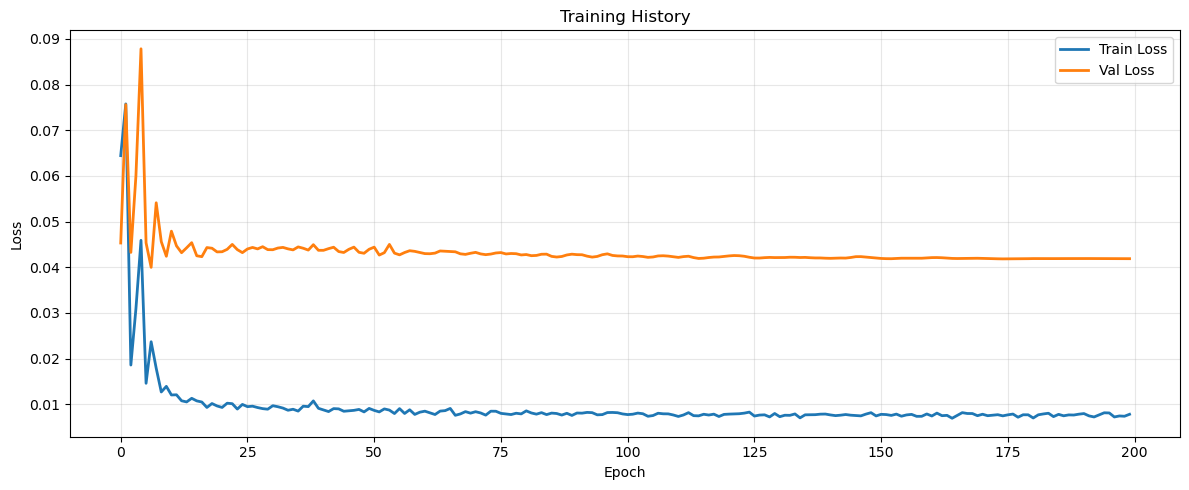

In [5]:
plot_training_history(train_losses, val_losses)

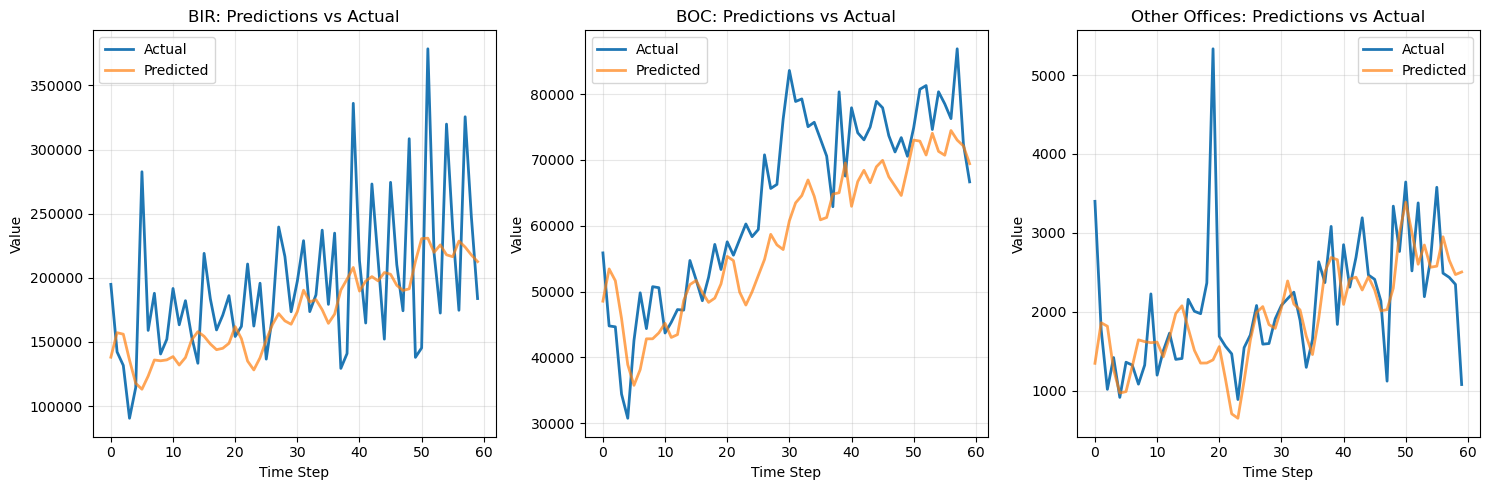

In [6]:
plot_test_predictions(test_preds, test_loader)